In [1]:
from deepforest import deepforest
from matplotlib import pyplot as plt
from deepforest import utilities
from deepforest import preprocess
import glob
import pandas as pd
import cv2
import numpy as np
import os
import comet_ml

Using TensorFlow backend.


# Goal

The aim of this notebook is to explore retraining deepforest on a small number of bird images in the everglades project.

In [2]:
model = deepforest.deepforest()
model.use_release()

Reading config file: /Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/deepforest/data/deepforest_config.yml
A blank deepforest object created. To perform prediction, either train or load an existing model.
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/v0.2.1 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/v0.2.1

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Just for fun, trees!

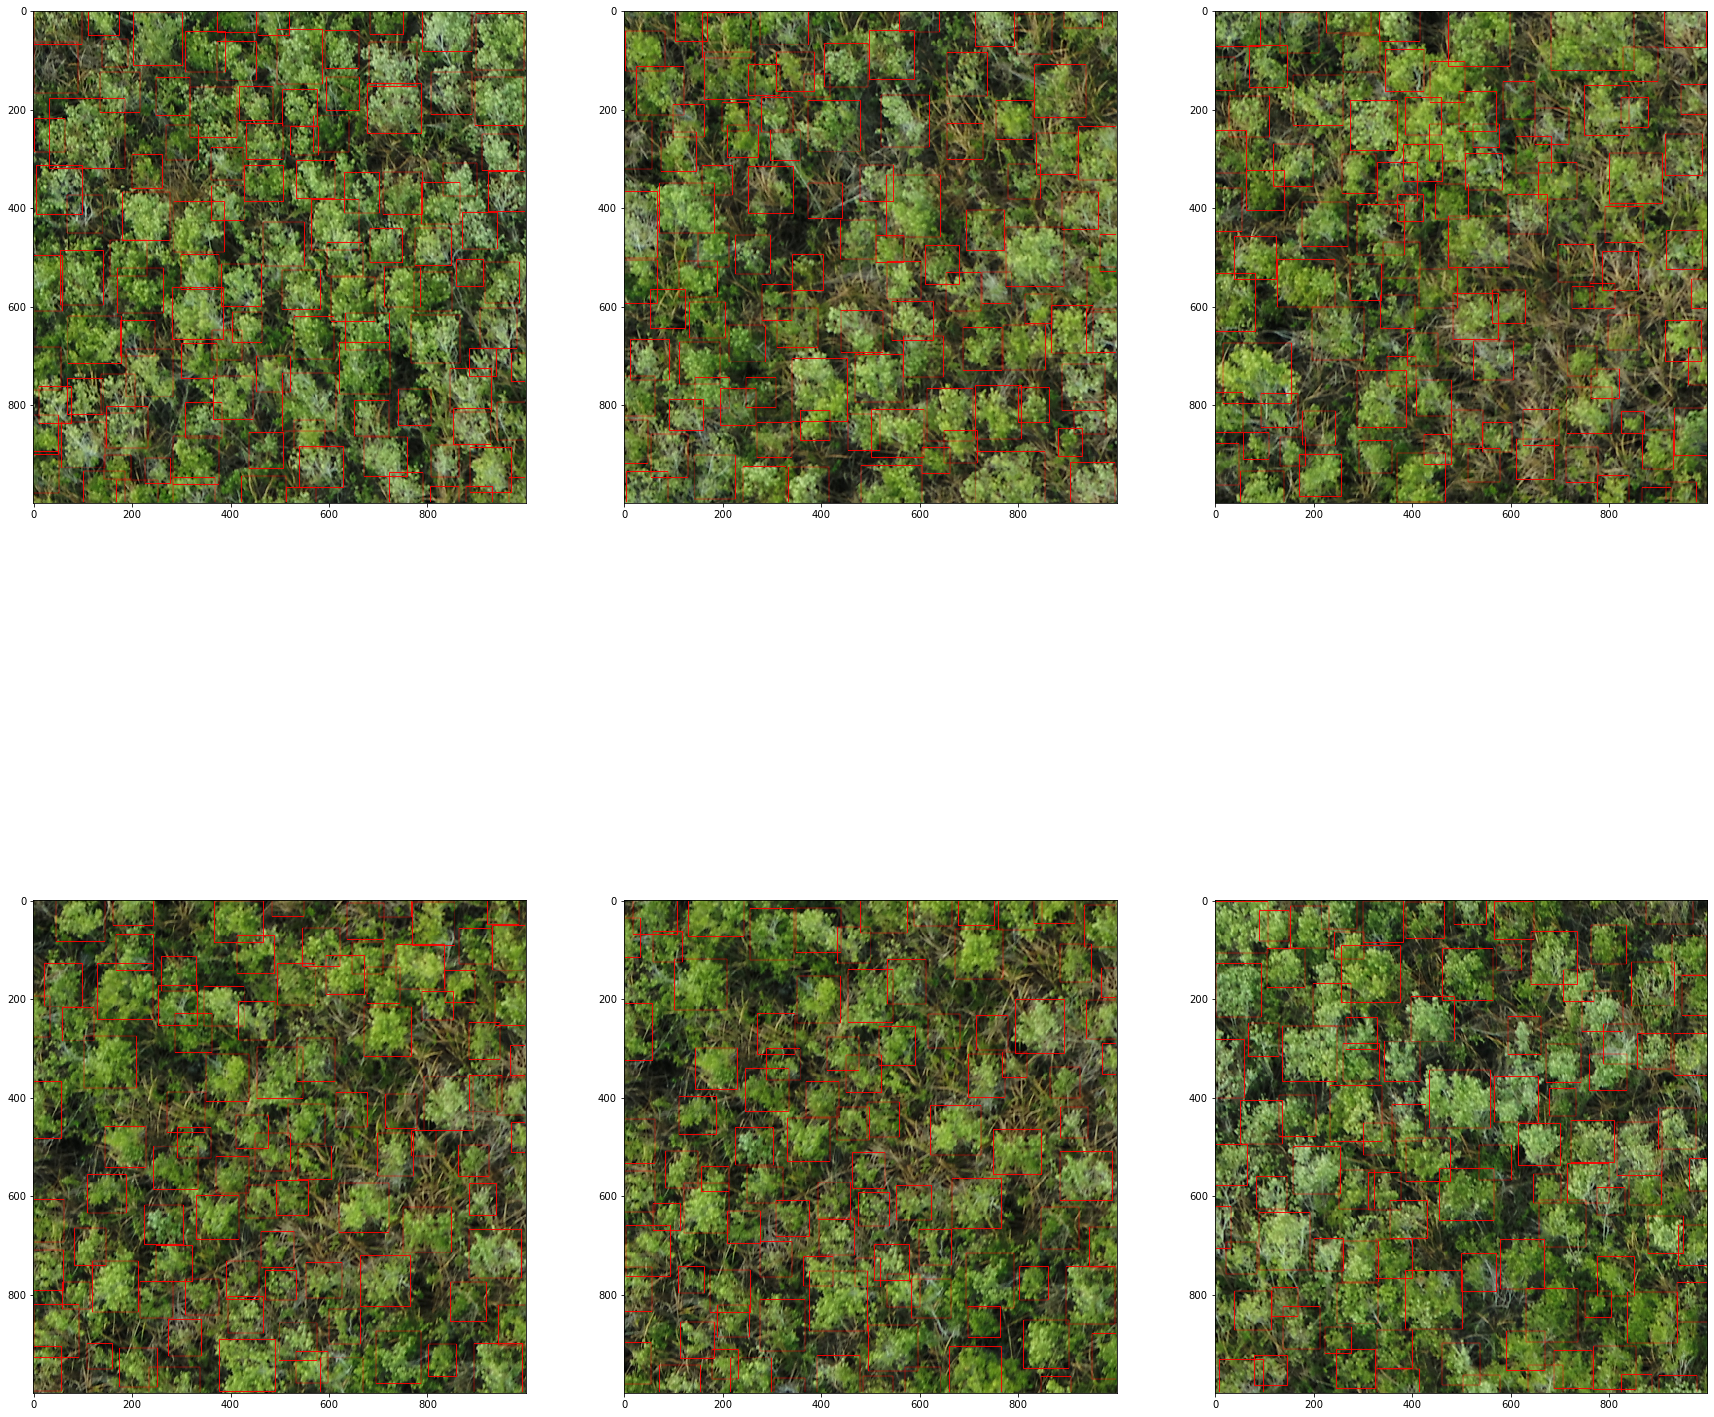

In [3]:
raster_path = "drone/DJI_0160.JPG"
numpy_image = cv2.imread(raster_path)
windows = preprocess.compute_windows(numpy_image, patch_size=1000,patch_overlap=0.05)
fig, axes, = plt.subplots(nrows=2,ncols=3, figsize=(30,30))
axes = axes.flatten()
for index in range(6):
    crop = numpy_image[windows[index].indices()] 
    #predict in bgr channel order
    prediction = model.predict_image(numpy_image = crop[...,::-1],return_plot=True, score_threshold=0.05, color = (255,0,0))
    #but plot in rgb channel order
    axes[index].imshow(prediction)

## Format bird annotations

In [4]:
#convert hand annotations from xml into retinanet format
xmls = glob.glob("drone/*.xml")
annotation = []
for xml in xmls:
    parse = utilities.xml_to_annotations(xml)
    annotation.append(parse)

annotation = pd.concat(annotation)
#For the training task, turn all labels to bird.
annotation["label"] == "Bird"

#Write converted dataframe to file. Saved alongside the images
annotation.to_csv("output/drone_example.csv", index=False)

#Find image data on path and split into windows
images = glob.glob("drone/*.JPG")

#Just the images that have been annotation
images = [x for x in images if os.path.basename(x) in annotation.image_path.unique()]
print("Found {} x images: {}".format(len(images),images))
window_annotations = []
for i in images:
    proccessed_annotations = preprocess.split_raster(path_to_raster=i,
                                     annotations_file="output/drone_example.csv",
                                     patch_size=400,
                                     base_dir = "output/",
                                     patch_overlap=0,
                                     allow_empty=True)
    window_annotations.append(proccessed_annotations)
    
window_annotations = pd.concat(window_annotations)

#Split into training and (tiny) test, allow for some empty windows
empty_annotations = window_annotations[window_annotations.label == ""] 
non_empty_annotations = window_annotations[~(window_annotations.label == "")] 

train_image_paths = pd.Series(non_empty_annotations.image_path.unique()).sample(frac=0.8)
train_annotations = non_empty_annotations[non_empty_annotations.image_path.isin(train_image_paths)]
test_annotations =  non_empty_annotations[~(non_empty_annotations.image_path.isin(train_image_paths))]

Found 19 x images: ['drone/DJI_0046.JPG', 'drone/DJI_0051.JPG', 'drone/DJI_0130.JPG', 'drone/DJI_0068.JPG', 'drone/DJI_0018.JPG', 'drone/DJI_0030.JPG', 'drone/DJI_0024.JPG', 'drone/DJI_0032.JPG', 'drone/DJI_0149_eval.JPG', 'drone/DJI_0023.JPG', 'drone/DJI_0022.JPG', 'drone/DJI_0009.JPG', 'drone/DJI_0010.JPG', 'drone/DJI_0003.JPG', 'drone/DJI_0029.JPG', 'drone/DJI_0160.JPG', 'drone/DJI_0075.JPG', 'drone/DJI_0115.JPG', 'drone/DJI_0048.JPG']


In [5]:
#add back in some empty windows and combine
test_empty_annotations = empty_annotations[~(empty_annotations.image_path.isin(test_annotations.image_path.unique()))].sample(n=10)
train_empty_annotations = empty_annotations[empty_annotations.image_path.isin(test_empty_annotations.image_path.unique())].sample(n=10)
train_annotations = pd.concat([train_annotations, train_empty_annotations])
test_annotations = pd.concat([test_annotations, test_empty_annotations])

#View output
train_annotations.head()

#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations_path = "output/train.csv"
train_annotations.to_csv(train_annotations_path,index=False, header=None)

test_annotations_path = "output/test.csv"
test_annotations.to_csv(test_annotations_path,index=False, header=None)

In [6]:
model.config["validation_annotations"] = "output/test.csv"
model.config["epochs"] = 10
model.config["save_path"] = "output/"

In [7]:
model.train(train_annotations_path)

There are 3 unique labels: ['White Bird', 'Great Blue Heron', 'Gator'] 
Disabling snapshot saving
Training retinanet with the following args ['--weights', '/Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/deepforest/data/NEON.h5', '--backbone', 'resnet50', '--image-min-side', '800', '--multi-gpu', '1', '--epochs', '10', '--steps', '157', '--batch-size', '1', '--tensorboard-dir', 'None', '--workers', '1', '--max-queue-size', '10', '--freeze-layers', '0', '--score-threshold', '0.05', '--save-path', 'output/', '--snapshot-path', 'snapshots/', '--no-snapshots', 'csv', 'output/train.csv', 'output/classes.csv', '--val-annotations', 'output/test.csv']
Creating model, this may take a second...


/Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 27) vs (9, 256, 3, 3)).
  weight_values[i].shape))
/Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((27,) vs (9,)).
  weight_values[i].shape))


tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)        

Epoch 1/10
157/157 [==============================] - 1112s 7s/step - loss: 2.6816 - regression_loss: 1.6372 - classification_loss: 1.0445


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:31 Time:  0:01:31
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.0000
11 instances of class Great Blue Heron with average precision: 0.0000
0 instances of class Gator with average precision: 0.0000
mAP: 0.0000
Epoch 2/10
157/157 [==============================] - 1114s 7s/step - loss: 2.3795 - regression_loss: 1.3423 - classification_loss: 1.0373


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:19 Time:  0:01:19
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.0000
11 instances of class Great Blue Heron with average precision: 0.0000
0 instances of class Gator with average precision: 0.0000
mAP: 0.0000
Epoch 3/10
157/157 [==============================] - 1096s 7s/step - loss: 2.0782 - regression_loss: 1.1922 - classification_loss: 0.8860


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:19 Time:  0:01:19
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.8234
11 instances of class Great Blue Heron with average precision: 0.0000
0 instances of class Gator with average precision: 0.0000
mAP: 0.4117
Epoch 4/10
157/157 [==============================] - 1085s 7s/step - loss: 1.5564 - regression_loss: 1.0826 - classification_loss: 0.4738


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:19 Time:  0:01:19
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.8225
11 instances of class Great Blue Heron with average precision: 0.0000
0 instances of class Gator with average precision: 0.0000
mAP: 0.4112
Epoch 5/10
157/157 [==============================] - 1128s 7s/step - loss: 1.4653 - regression_loss: 1.0579 - classification_loss: 0.4073


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:36 Time:  0:01:36
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.8755
11 instances of class Great Blue Heron with average precision: 0.0544
0 instances of class Gator with average precision: 0.0000
mAP: 0.4650
Epoch 6/10
157/157 [==============================] - 1245s 8s/step - loss: 1.3101 - regression_loss: 0.9665 - classification_loss: 0.3436


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:47 Time:  0:01:47
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.8331
11 instances of class Great Blue Heron with average precision: 0.0433
0 instances of class Gator with average precision: 0.0000
mAP: 0.4382
Epoch 7/10
157/157 [==============================] - 1271s 8s/step - loss: 1.1765 - regression_loss: 0.8780 - classification_loss: 0.2986


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:31 Time:  0:01:31
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.9203
11 instances of class Great Blue Heron with average precision: 0.0784
0 instances of class Gator with average precision: 0.0000
mAP: 0.4994
Epoch 8/10
157/157 [==============================] - 1435s 9s/step - loss: 1.0765 - regression_loss: 0.8000 - classification_loss: 0.2766


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:24 Time:  0:01:24
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.9095
11 instances of class Great Blue Heron with average precision: 0.1186
0 instances of class Gator with average precision: 0.0000
mAP: 0.5141
Epoch 9/10
157/157 [==============================] - 1126s 7s/step - loss: 0.9805 - regression_loss: 0.7424 - classification_loss: 0.2381


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:22 Time:  0:01:22
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.8595
11 instances of class Great Blue Heron with average precision: 0.2646
0 instances of class Gator with average precision: 0.0000
mAP: 0.5621
Epoch 10/10
157/157 [==============================] - 1111s 7s/step - loss: 0.9027 - regression_loss: 0.6834 - classification_loss: 0.2193


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:21 Time:  0:01:21
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.7410
11 instances of class Great Blue Heron with average precision: 0.1735
0 instances of class Gator with average precision: 0.0000
mAP: 0.4572


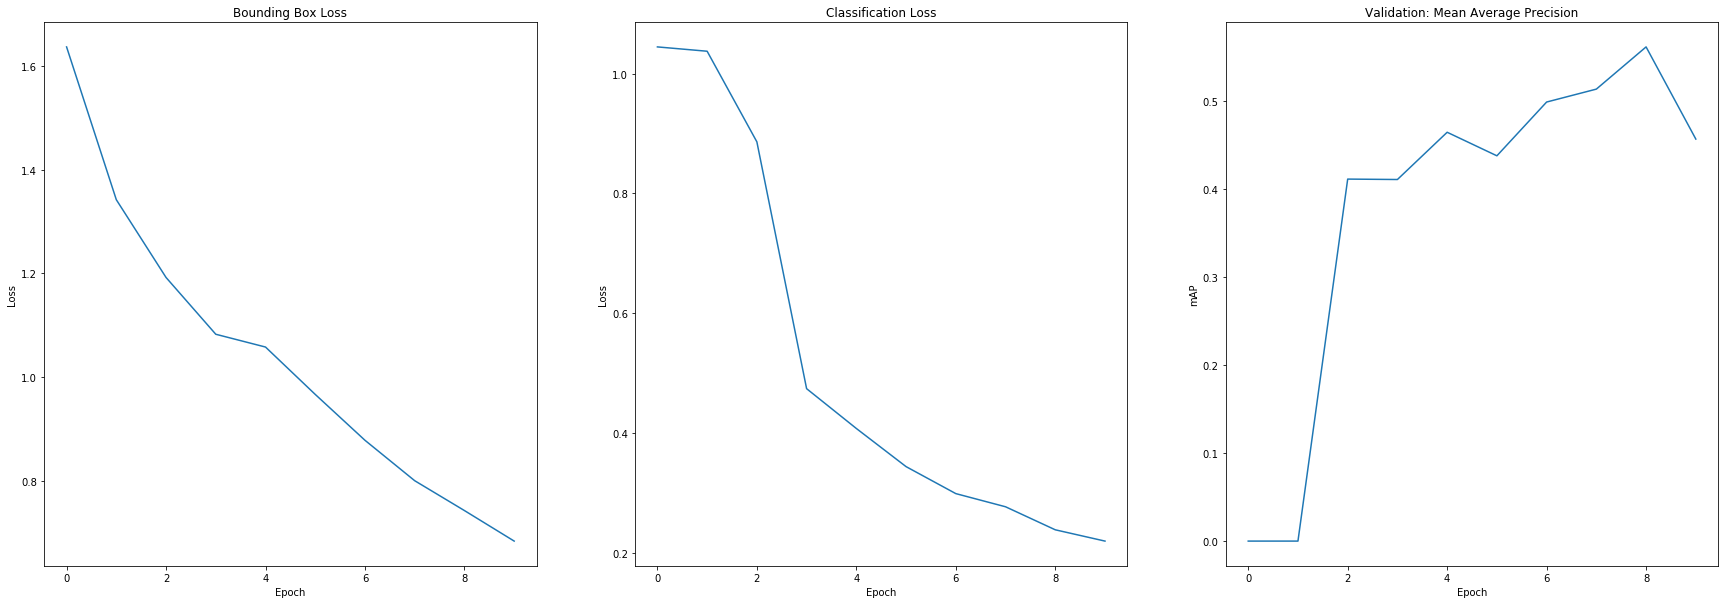

In [8]:
# Plot training & validation regression loss values
fig, axes, = plt.subplots(nrows=1,ncols=3,figsize=(30,10))
axes = axes.flatten()

#Regression Loss
axes[0].plot(model.model.history.history['regression_loss'])
axes[0].set_title('Bounding Box Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')

#Classification Loss        
axes[1].plot(model.model.history.history['classification_loss'])
axes[1].set_title('Classification Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

# Plot validation mAP
if "mAP" in model.model.history.history.keys():
    axes[2].plot(model.model.history.history['mAP'])
    axes[2].set_title('Validation: Mean Average Precision')
    axes[2].set_ylabel('mAP')
    axes[2].set_xlabel('Epoch')

In [9]:
model.evaluate_generator(test_annotations_path)

Running network: N/A% (0 of 47) |        | Elapsed Time: 0:00:00 ETA:  --:--:--

There are 2 unique labels: ['White Bird', 'Great Blue Heron'] 
Disabling snapshot saving


Running network: 100% (47 of 47) |#######| Elapsed Time: 0:01:21 Time:  0:01:21
Parsing annotations: 100% (47 of 47) |###| Elapsed Time: 0:00:00 Time:  0:00:00


31 instances of class White Bird with average precision: 0.7410
11 instances of class Great Blue Heron with average precision: 0.1735
mAP using the weighted average of precisions among classes: 0.5923
mAP: 0.4572


0.45722798182001223

In [10]:
fixed_winged_data = "/Users/ben/Dropbox/Everglades/Zooniverse/fixed_winged_data/IMG_2287.JPG"

In [16]:
prediction = model.predict_tile(fixed_winged_data,patch_overlap=0,patch_size=400, return_plot=True, iou_threshold=0.9)

619 predictions in overlapping windows, applying non-max supression
493 predictions kept after non-max suppression


True

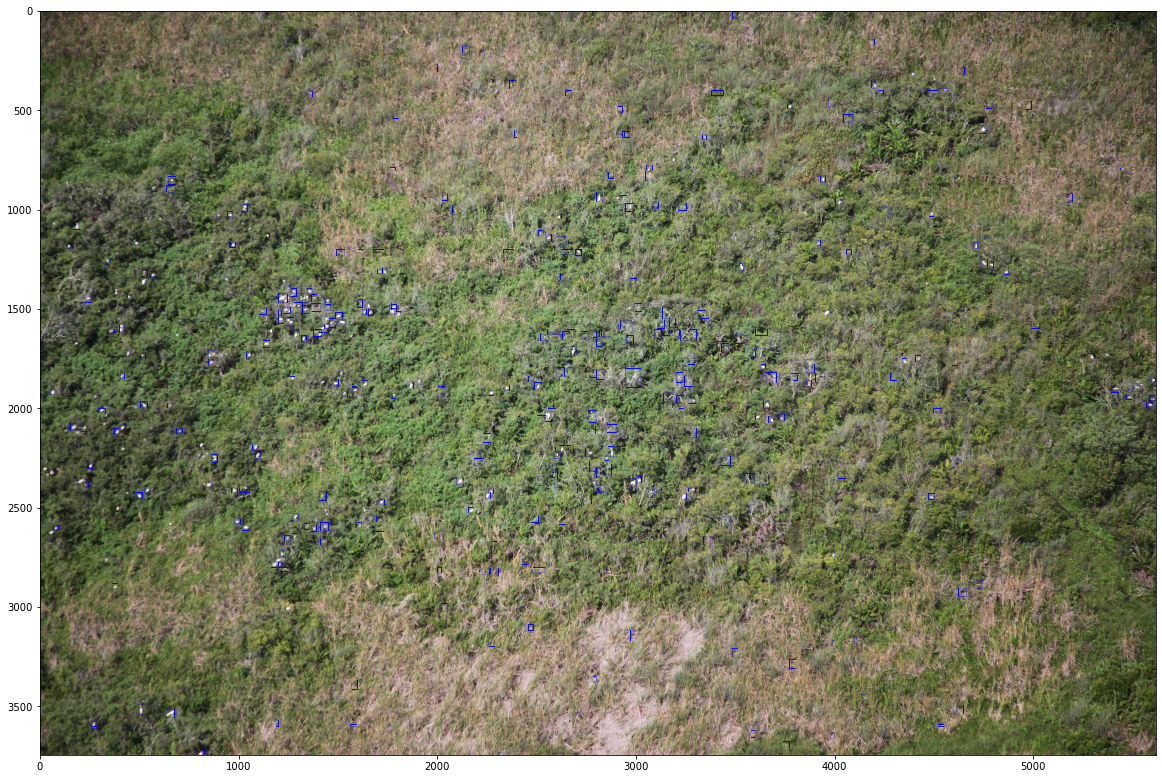

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(prediction)
cv2.imwrite("output/IMG_2287.JPG",prediction[:,:,::-1])